# Bayesian 3D Full Waveform Inversion (3D FWI)

In this tutorial, we display 3D FWI results obtained using GeoPVI and an external acoustic 3D FWI (forward and adjoint) solver. The code example can be found in `GeoPVI/examples/fwi3d` and in the user manual in `GeoPVI/doc`.

Currently, only PSVI results are displayed in this tutorial.

## Import libraries

In [1]:
import numpy as np
import torch
import scipy.sparse as sparse
import geopvi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
torch.set_default_dtype(torch.float64)

## Define necessary functions

In [3]:
def cons_2_real(x, lower, upper):
    z = np.log(x - lower) - np.log(upper - x)
    return z

def real_2_cons(x, lower, upper):
    z = lower + (upper - lower) / (1 + np.exp(-x))
    return z

def real_const(x, lower, upper):
    z = lower + (upper - lower) / (1 + np.exp(-x))
    log_det = (np.log(upper - lower) - x - 2 * np.log(1 + np.exp(-x)))
    return z, log_det

def const_real(x, lower, upper):
    z = np.log(x - lower) - np.log(upper - x)
    log_det = np.log(1 / (x - lower) + 1 / (upper - x))
    return z, log_det

The following functions are defined to plot the inversion results.

In [28]:
def marginal_2d(sample, dvel, dim = 50):
    marginal = np.zeros([dim, dvel.size])
    for i in range(dim):
        sample_i = sample[:,i]
        tmp = (sample_i < dvel[:,None]).mean(axis = 1)
        tmp[1:] = np.diff(tmp)
        marginal[i] = tmp
        
    return marginal / (dvel[1] - dvel[0])

In [4]:
def plot_2dmaps_with_true_model(axs, vel_true, samples, clim, axis_name = ['X', 'Y'], dx = 0.05, dy = 0.05):
    mean = samples.mean(axis = 0).T
    std = samples.std(axis = 0).T
    error = np.abs(vel_true.T - mean) / std
    ny, nx = mean.shape
    for i in range(axs.size):
        if i == 0:
            im = ax[i].imshow(vel_true.T, cmap = 'jet', clim = clim[i], extent=[0,nx*dx,ny*dy, 0])
            ax[i].set_ylabel(f'{axis_name[1]} (km)', fontsize=20)
            string = 'Velocity (m/s)'
        elif i == 1:
            im = ax[i].imshow(mean, cmap = 'jet', clim = clim[i], extent=[0,nx*dx,ny*dy, 0])
            string = 'Mean (m/s)'
        elif i == 2:
            im = ax[i].imshow(std, clim = clim[i], extent=[0,nx*dx,ny*dy, 0])
            string = 'Std (m/s)'
        elif i == 3:
            im = ax[i].imshow(error, clim = clim[i], extent=[0,nx*dx,ny*dy, 0])
            string = 'Error/Std'
        ax[i].set_xlabel(f'{axis_name[0]} (km)', fontsize=20)
        ax[i].set_yticks(np.arange(0, ny*dy))
        ax[i].set_xticks(np.arange(0, nx*dx))
        ax[i].tick_params(axis="y", labelsize=12)
        ax[i].tick_params(axis="x", labelsize=12)
        
        divider = make_axes_locatable(ax[i])
        cax = divider.append_axes("right",size="3%",pad=0.1)
        cbar = plt.colorbar(im, cax = cax, orientation="vertical")
        cbar.set_label(string, fontsize=14)

In [6]:
def extend_trace(sample, vel_ext, water_layer):
    sample_new = np.full((sample.shape[0], nz), vel_ext)
    sample_new[:,water_layer:] = sample
    return sample_new

In [5]:
def extend_model(x, vel_ext, mask, vel_true):
    mean = np.full(mask.shape, vel_ext)
    std = np.zeros(mask.shape)
    error = np.zeros(mask.shape)
    mean[mask] = x.mean(axis = 0)
    std[mask] = x.std(axis = 0)
    error[mask] = np.abs(mean[mask] - vel_true[mask]) / std[mask]
    return mean, std, error

## Define FWI parameters

#### Set your own GeoPVI path here

In [16]:
geopvi_path = '/home/GeoPVI/'

In [7]:
water_layer = 1
nx = 101
ny = 101
nz = 63
ns = 81
dz = 50
dx = 50
dy = 50

ndim = ny * nx * (nz - water_layer)

#### Define a mask denoting which parameters are fixed during inversion (within the water layer)

In [8]:
mask_inv = np.full([ny, nx, nz], True)
mask_inv[:,:,:water_layer] = False

#### Acquision geometry

In [9]:
ncables = 9
cable_spacing = 0.5
nrecs_per_cable = 9
rec_spacing = 0.5

nshotlines = 101
shotline_spacing = 0.05
nshots_per_line = 101
shot_spacing = 0.05

shotxy = np.zeros((nshotlines,nshots_per_line,2),dtype=np.float32)
recxy = np.zeros((ncables,nrecs_per_cable,2),dtype=np.float32)

for i in range(ncables):
    for j in range(nrecs_per_cable):
        recxy[i,j,0] = j*rec_spacing + 0.5
        recxy[i,j,1] = i*cable_spacing + 0.5

for i in range(nshotlines):
    for j in range(nshots_per_line):
        shotxy[i,j,0] = i*shotline_spacing
        shotxy[i,j,1] = j*shot_spacing

Text(0, 0.5, 'Y (km)')

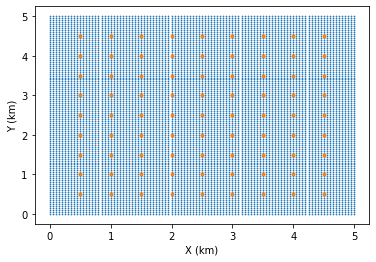

In [11]:
plt.scatter(shotxy[:,:,0],shotxy[:,:,1],s=.5)
plt.scatter(recxy[:,:,0],recxy[:,:,1],s=8)
plt.xlabel('X (km)'); plt.ylabel('Y (km)')

#### Display true velocity model

In [13]:
vel_true = np.load(geopvi_path + 'examples/fwi3d/input/vel_true.npy')

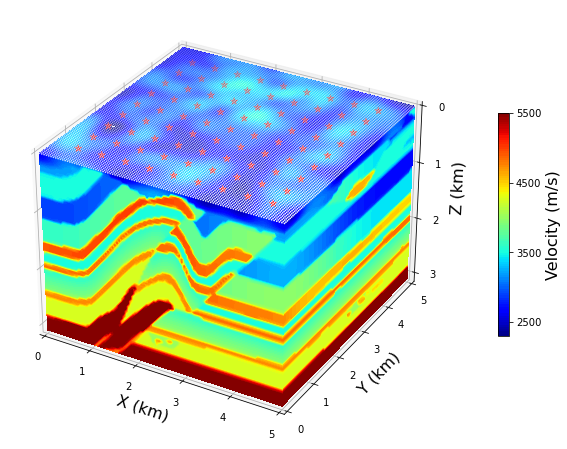

In [15]:
# Define dimensions
Nx, Ny, Nz = 101, 101, 63
X, Y, Z = np.meshgrid(np.arange(Nx)*0.05, np.arange(Ny)*0.05, np.arange(Nz)*0.05)

# Create fake data
data = vel_true

kw = {
    'vmin': data.min(),
    'vmax': data.max(),
    'levels': np.linspace(2300, 5500, 100),
}

# Create a figure with 3D ax
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot contour surfaces
_ = ax.contourf(
    X[:, :, 0], Y[:, :, 0], data[:, :, 0],cmap = 'jet',
    zdir='z', offset=0, **kw
)
_ = ax.scatter(recxy[:,:,0],recxy[:,:,1],s=50, c= 'red', zdir='z', marker='*')
_ = ax.scatter(shotxy[:,:,0],shotxy[:,:,1],s=0.5, c= 'white', zdir='z')
_ = ax.contourf(
    X[0, :, :], data[0, :, :], Z[0, :, :],cmap = 'jet',
    zdir='y', offset=0, **kw
)
C = ax.contourf(
    data[:, -1, :], Y[:, -1, :], Z[:, -1, :],cmap = 'jet',
    zdir='x', offset=X.max(), **kw
)

# Set limits of the plot from coord limits
xmin, xmax = X.min()-0., X.max()+0.
ymin, ymax = Y.min()-0., Y.max()+0.
zmin, zmax = Z.min()-0., Z.max()+0.
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

ax.invert_zaxis()
ax.set(zticks=[0, 1,2,3])

ax.set_ylabel('Y (km)', fontsize=16)
ax.set_xlabel('X (km)', fontsize=16)
ax.set_zlabel('Z (km)', fontsize=16)

# Colorbar
cbar = fig.colorbar(C, ax=ax, fraction=0.02, pad=0.1, ticks = [2500, 3500, 4500, 5500])
cbar.set_label('Velocity (m/s)', fontsize=16)

plt.show()

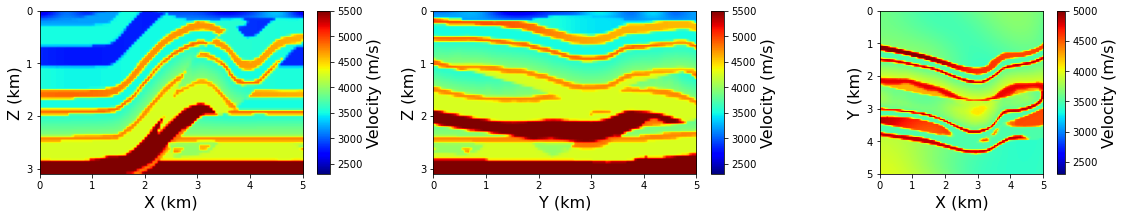

In [17]:
iy = 50
ix = 50
iz = 25

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 3))
im = ax[0].imshow(vel_true.reshape(ny,nx,nz)[iy,:,water_layer:].T, cmap = 'jet', clim = (2300, 5500), extent=[0,5,3.1, 0])
ax[0].set_ylabel('Z (km)', fontsize=16)
ax[0].set_xlabel('X (km)', fontsize=16)
ax[0].set_yticks([0, 1, 2, 3])
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right",size="5%",pad=0.2)
cbar = plt.colorbar(im, cax = cax)
cbar.set_label('Velocity (m/s)', fontsize=16)

im = ax[1].imshow(vel_true.reshape(ny,nx,nz)[:,ix,water_layer:].T, cmap = 'jet', clim = (2300, 5500), extent=[0,5,3.1, 0])
rect = patches.Rectangle((48*0.05, 44*0.05), 8*0.05, 8*0.05, linewidth=2, edgecolor='w', facecolor='none')
ax[1].set_ylabel('Z (km)', fontsize=16)
ax[1].set_xlabel('Y (km)', fontsize=16)
ax[1].set_yticks([0, 1, 2, 3])
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right",size="5%",pad=0.2)
cbar = plt.colorbar(im, cax = cax)
cbar.set_label('Velocity (m/s)', fontsize=16)

im = ax[2].imshow(vel_true.reshape(ny,nx,nz)[:,:,iz].T, cmap = 'jet', clim = (2300, 5000), extent=[0,5,5, 0])
ax[2].set_ylabel('Y (km)', fontsize=16)
ax[2].set_xlabel('X (km)', fontsize=16)
ax[2].set_yticks([0, 1, 2, 3, 4, 5])
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right",size="5%",pad=0.2)
cbar = plt.colorbar(im, cax = cax)
cbar.set_label('Velocity (m/s)', fontsize=16)

plt.show()

#### Load Uniform prior distribution

In [18]:
prior = np.loadtxt(geopvi_path + 'examples/fwi3d/input/Uniform_prior.txt')
lower = prior[water_layer:,0].astype(np.float64)
upper = prior[water_layer:,1].astype(np.float64)
lower = np.broadcast_to(lower[None, None, :],(ny, nx, (nz - water_layer))).flatten()
upper = np.broadcast_to(upper[None, None, :],(ny, nx, (nz - water_layer))).flatten()

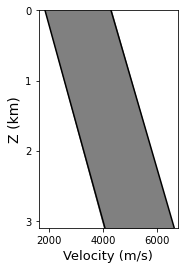

In [21]:
depth = np.arange(nz)

plt.figure(figsize = (2.5,4))
plt.plot(prior[:,0], depth*0.05, color = 'black')
plt.plot(prior[:,1], depth*0.05, color = 'black')
plt.fill_betweenx(np.linspace(0, 3.15, prior.shape[0]), prior[:,0], x2 = prior[:,1], color = 'grey')
plt.ylabel('Z (km)', fontsize=14)
plt.xlabel('Velocity (m/s)', fontsize=13)
plt.yticks([0, 1, 2, 3])
plt.xticks([2000, 4000, 6000])
plt.xlim(1600,6800)
plt.ylim(0,3.1)
plt.gca().invert_yaxis()
plt.show()

## Load inversion results

### epsilons: samples from base distribution (Standard normal in this case)

In [22]:
nsample = 1000
ndim = lower.size
epsilons = np.random.normal(size = (nsample, ndim))

### PSVI: the correlation kernel size is 5\*5\*5 in this example.

FIrst, given the optimised variational parameters, construct a sparse matrix L using scipy.sparse.

Then, posterior samples can be obtained by $\theta = \mu + \mathbf{L}\epsilon$, followed by a real_2_cons transform.

In [25]:
param = np.load(geopvi_path + 'examples/fwi3d/output/Linear_structured_parameter.npy')
print(param.reshape(-1, ndim).shape)

mus = param[:ndim]
sigmas = param[ndim:2*ndim]
diags = param[1*ndim:].reshape(-1, ndim)
print(diags.shape)

if diags.shape[0] > 1:
    offset = (diags == 0).sum(axis = 1)
    L = sparse.diags(diags, -offset, shape = (ndim, ndim))
if diags.shape[0] > 1:
    print('PSVI')
    theta = mus + (L @ epsilons.T).T
else:
    print('ADVI')
    theta = mus + epsilons * sigmas

psvi = real_2_cons(theta, lower, upper)

(64, 632462)
(63, 632462)
PSVI


## Display inversion results

### 1. Mean, standard deviation and relative error maps

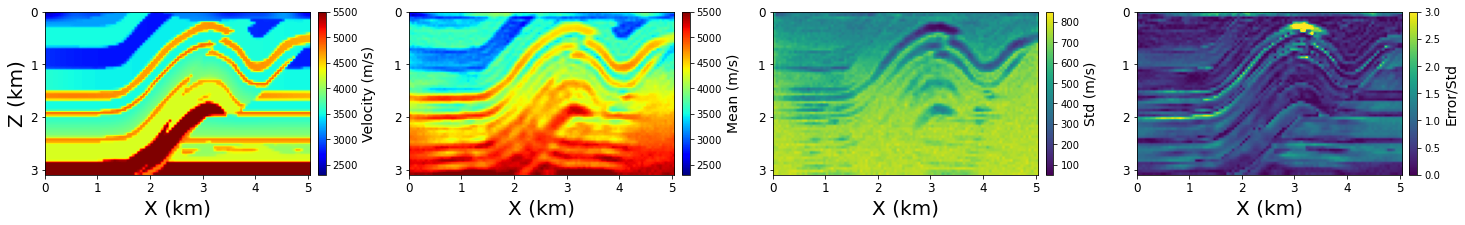

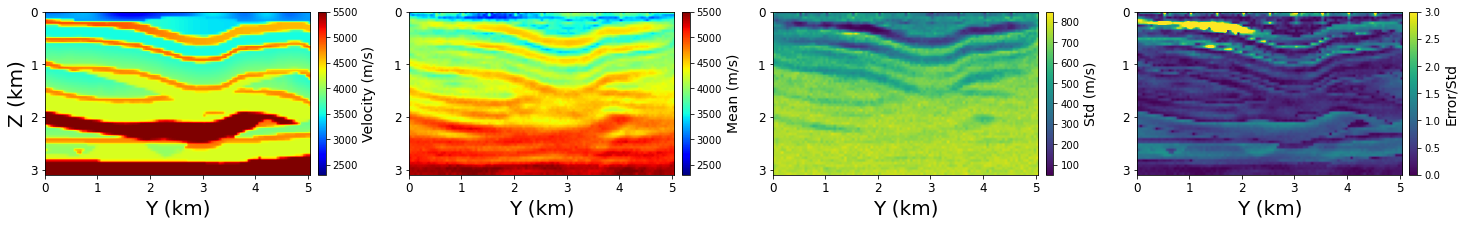

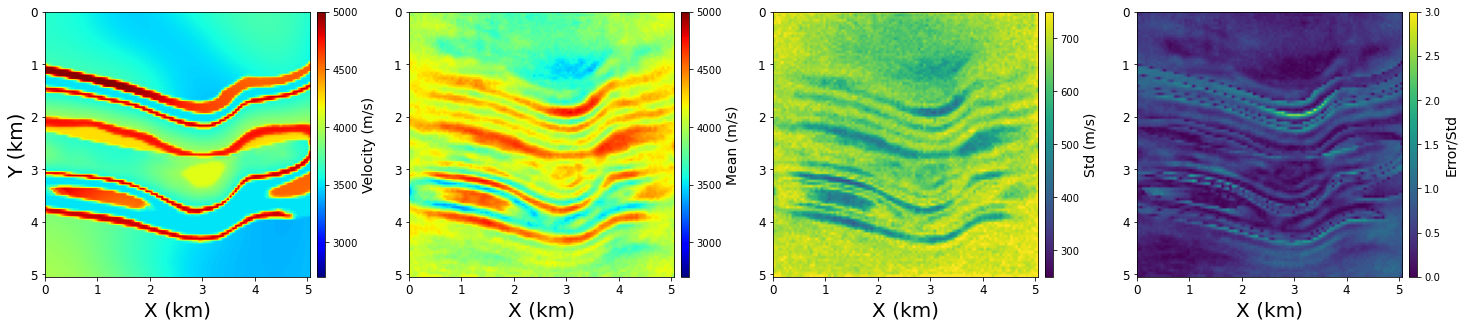

In [26]:
nrow = 1
ncol = 4

iy = 55
ix = 50
iz = 25

samples = psvi

clim = [(2300,5500), (2300,5500), (50,850), (0, 3)]
vel = samples.reshape(-1, ny, nx, nz - water_layer)[:,iy,:,:]
v = vel_true.reshape(ny,nx,nz)[iy,:,water_layer:]

fig, ax = plt.subplots(nrows = nrow, ncols = ncol, figsize = (25, 3))
plot_2dmaps_with_true_model(ax, v, vel, clim, axis_name = ['X', 'Z'])
plt.show()


clim = [(2300,5500), (2300,5500), (50,850), (0, 3)]
vel = samples.reshape(-1, ny, nx, nz - water_layer)[:,:,ix,:]
v = vel_true.reshape(ny,nx,nz)[:, ix, water_layer:]

fig, ax = plt.subplots(nrows = nrow, ncols = ncol, figsize = (25, 3))
plot_2dmaps_with_true_model(ax, v, vel, clim, axis_name = ['Y', 'Z'])
plt.show()


clim = [(2700,5000), (2700,5000), (250,750), (0, 3)]
vel = samples.reshape(-1, ny, nx, nz - water_layer)[:,:,:,iz]
v = vel_true.reshape(ny,nx,nz)[:, :, water_layer + iz]

fig, ax = plt.subplots(nrows = nrow, ncols = ncol, figsize = (25, 4.88))
plot_2dmaps_with_true_model(ax, v, vel, clim, axis_name = ['X', 'Y'])
plt.show()

### 2. Posterior marginal pdf's

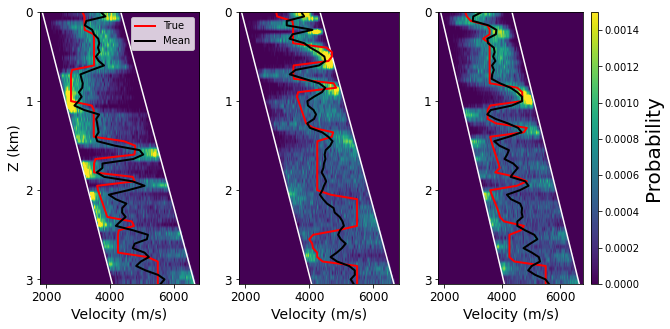

In [30]:
nrow = 1
ncol = 3

delta_x = np.arange(0,1,0.001)

ys = [50, 50, 50]
xs = [25, 50, 75]
fig, ax = plt.subplots(nrows = nrow, ncols = ncol, figsize = (10, 5))

for j in range(ncol):
    iy = ys[j]
    ix = xs[j]
    sample_trace = psvi.reshape([psvi.shape[0], ny, nx, -1])[:,iy,ix,:]
    dvel = 1800 + (6800 - 1800) * delta_x
    marginal_trace = marginal_2d(sample_trace, dvel, (nz - water_layer))
    im = ax[j].imshow(marginal_trace, extent = [1800,6800,3.05,0], aspect = 'auto', clim = [0,0.0015])
    if i == 0:
        ax[i,j].set_title(title[j], fontsize = 14)
    ax[j].plot(prior[water_layer:,0], np.arange((nz - water_layer))*0.05, color = 'white')
    ax[j].plot(prior[water_layer:,1], np.arange((nz - water_layer))*0.05, color = 'white')

    v = vel_true[iy,ix,water_layer:]
    ax[j].plot(v, np.arange(0, (nz - water_layer))*0.05, color = 'red', linewidth = 2, label = 'True')
    mean = sample_trace.mean(axis = 0)
    std = sample_trace.std(axis = 0)
    ax[j].plot(mean, np.arange(0, (nz-water_layer))*0.05, color = 'black', linewidth = 2, label = 'Mean')
    if j == 0:
        ax[j].legend()

    if j == 0:
        ax[j].set_ylabel('Z (km)', fontsize=14)
    ax[j].set_yticks([0, 1, 2, 3])
    ax[j].tick_params(axis="y", labelsize=12)
    ax[j].tick_params(axis="x", labelsize=12)

    ax[j].set_xlabel('Velocity (m/s)', fontsize=14)
    ax[j].set_xticks([2000, 4000, 6000])

    if j == ncol - 1:
        divider = make_axes_locatable(ax[j])
        cax = divider.append_axes("right",size="5%",pad=0.1)
        cbar = plt.colorbar(im, cax = cax)
        cbar.set_label('Probability', fontsize=20)

fig.subplots_adjust(wspace=0.25, hspace=0.2)
plt.show()